# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

New York has an estimated 18,804,000 people, a very densely populated and culturally diverse major city in the United States. It consists of five boroughs — Brooklyn, Queens, Manhattan, Bronx and Staten Island, and more than 300 neighborhoods. Our goal is to find a good neighborhood for opening a **Mexican Restaurant** in New York and what the competive landscape looks like. 


**Target Audience:**

1. Individuals looking into opening a Mexican restaurant. This will provide an analysis of whether the venture is feasible and what the competitive landscape is.

2. Investors that seek to invest in the opening of the company. This analysis will highlight potential areas to start or expand a business.

3. Residents or visitors looking for Mexican restaurants.


A good location is a safe place with good amount of consumers’ footfall who can afford the product and where the cost of doing business is optimum. This means data required for this purpose are: population density, demographics, purchasing power, and competitors. In this project, data on population density, purchasing power (i.e, per capita income) and competitors (foursquare location data) has been used.


# Data <a name="data"></a>

In this project, first, we obtain the data that contains the boroughs and the neighborhoods of the New York City. It also contains the latitude and longitude of each neighborhood of every borough in the city. Later, using them, we obtain the data of food outlets/ eateries (along with their type) inside each Borough.

Before we get the data and start exploring it, here's the data we will need. 
    
1. New York city neighborhoods, boroughs, latitudes, and longitudes. This JSON file is what we will use to extract the ‘features’ data which has four columns ‘Borough’, ‘Neighborhood’, ‘Latitude’, ‘Longitude’. This dataset exists for free on the web. Here is the link

    * Links to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572, and to its downloadable json format file: https://cocl.us/new_york_dataset/newyork_data.json
     

2. We will leverage Foursquare data to display the current restaurants in each region. Description: Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighborhoods. 
    * Link: https://developer.foursquare.com/docs


3. We will scrape a webpage to obtain population density and per capita GDP of the five borough boroughs. 
    * Link: https://en.wikipedia.org/wiki/Demographics_of_New_York_City 

### First start by importing dependencies. 

In [1]:
# Importing Libraries

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import json # library to handle JSON files
from pprint import pprint # data pretty printer

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # library for converting address into lattitude and longitude

import requests # library to handle requests

from bs4 import BeautifulSoup # library for web scraping

import matplotlib.pyplot as plt # plotting library
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans # importing k-means from clustering stage
from collections import Counter # count occurrences 


!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from folium import plugins

print('Libraries imported')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported


### Download the data and install wget if neccessary


In [2]:
!pip install wget
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')




Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
type(newyork_data)

dict

In [4]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


All the relevant data is in the features key, which is the list of the neighborhoods. So, let's define a new variable that includes this data. We will print the tenth item in the list.

In [5]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[9])


{'geometry': {'coordinates': [-73.85744642974207, 40.88103887819211],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.10',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Williamsbridge',
                'annoline2': None,
                'annoline3': None,
                'bbox': [-73.85744642974207,
                         40.88103887819211,
                         -73.85744642974207,
                         40.88103887819211],
                'borough': 'Bronx',
                'name': 'Williamsbridge',
                'stacked': 1},
 'type': 'Feature'}


### Tranform the data into a pandas dataframe



In [6]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


### Loop through the data and fill the dataframe one row at a time



In [7]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Print the boroughs and neighborhoods for dataframe

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get the latitude and longitude values of New York City

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer. This will get location values of New York for folium maps.

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


### Creating map of New York using latitude and longitude values

In [10]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# Adding markers to map
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The above map shows all the neighborhoods of New York.

Now we will compare population density and per capita GDP for comparing Boroughs.

### Scrape population density and income data


In [11]:
res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_New_York_City")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]
df.head()

New York City's five boroughsvte                                \
                      Jurisdiction                    Population   
                           Borough    County Estimate (2018)[12]   
0                        The Bronx     Bronx             1432132   
1                         Brooklyn     Kings             2582830   
2                        Manhattan  New York             1628701   
3                           Queens    Queens             2278906   
4                    Staten Island  Richmond              476179   

                                                                \
  Gross Domestic Product                    Land area            
       billions(US$)[13] per capita(US$) square miles squarekm   
0                 42.695           29200        42.10   109.04   
1                 91.559           34600        70.82   183.42   
2                600.244          360900        22.83    59.13   
3                 93.310           39600       108.53   281.09   
4                 14.514           30300        58.37   151.18   

                                 
           Density               
  persons / sq. mi persons /km2  
0            34653        13231  
1            37137        14649  
2            72033        27826  
3            21460         8354  
4             8112         3132

### Transforming Data into a Dataframe


In [12]:

demo_df = pd.DataFrame(columns=['Borough','Population Density','per capita GDP'])

demo_df['Borough'] = df.iloc[0:5,0]
demo_df['Population Density'] = df.iloc[0:5,8]
demo_df['per capita GDP'] = df.iloc[0:5,4]
demo_df.loc[0,'Borough'] = 'Bronx'
demo_df['Population Density'] = demo_df['Population Density'].astype('int')
demo_df['per capita GDP'] = demo_df['per capita GDP'].astype('int')
demo_df['Borough'] = demo_df['Borough'].astype('str')

demo_df

,Borough,Population Density,per capita GDP
0,Bronx,13231,29200
1,Brooklyn,14649,34600
2,Manhattan,27826,360900
3,Queens,8354,39600
4,Staten Island,3132,30300


### Visualize the per capita GDP in each neighborhood


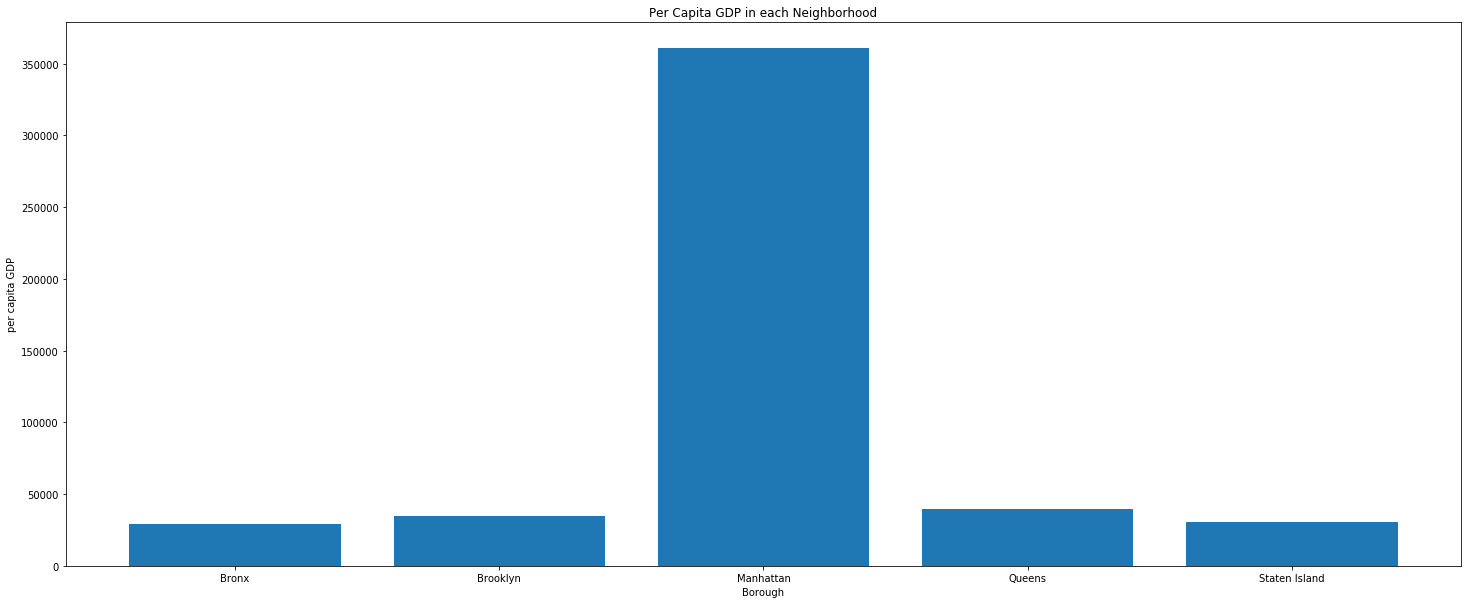

In [13]:
label = list(demo_df['Borough'])
height = list(demo_df['per capita GDP'])

index = np.arange(len(label))

plt.figure(figsize=(25,10))
plt.bar(index,height)
plt.xlabel('Borough')
plt.ylabel('per capita GDP')
plt.xticks(index,label)
plt.title('Per Capita GDP in each Neighborhood')
plt.show()

From the information we scrubbed, we can visually compare the per capita GDP in each neighborhood. 

Manhattan has the highest per capita income with great difference from the rest of the boroughs.


### Visualize the populaiton density in each neighborhood

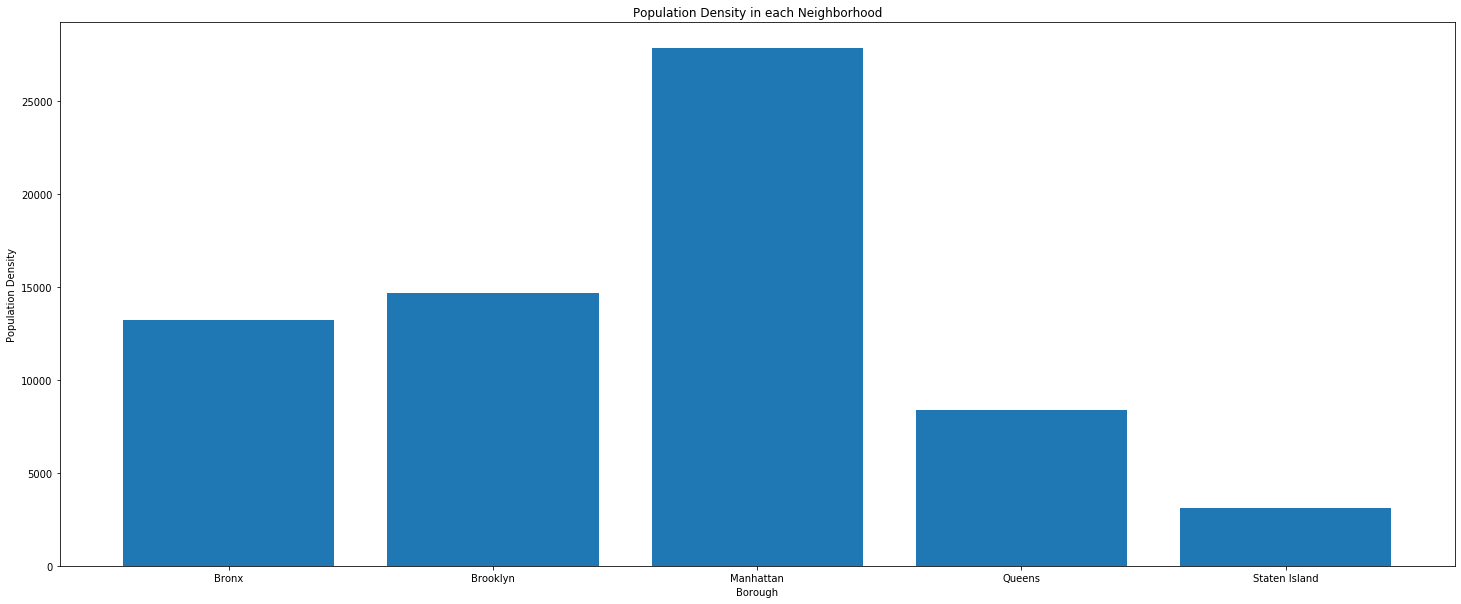

In [14]:
label = list(demo_df['Borough'])
height = list(demo_df['Population Density'])

index = np.arange(len(label))

plt.figure(figsize=(25,10))
plt.bar(index,height)
plt.xlabel('Borough')
plt.ylabel('Population Density')
plt.xticks(index,label)
plt.title('Population Density in each Neighborhood')
plt.show()

The above graph shows that Manhattan has the highest population density. Manhattan has more than double the population density of the rest of the boroughs.

**Analysis:** Manhattan has the highest population density and per capita income, which translates to a higher purchasing power. Since Manhattan has the highest for both, Manhattan will be ideal location to set up a new Mexican restaurant. We will now focus on Manhattan to figure out which neighborhood has the highest competition for Mexican restaurant.


# Methodology <a name="methodology"></a>

In this section, we will conduct **exploratory data analysis**. We have identified Manhattan as providing the highest population density and purchasing power. We will explore which neighborhood has the highest Mexican competition.


**Foursquare API will get information on restaurants in  Manhattan.

**In this section, we will perform predictive modeling of the data by using K-means clustering. In our problem, clustering helps to divide the neighborhoods of a given borough into clusters so that each neighborhood in a given cluster will show Mexican restaurants with respect to the other neighborhoods within the same cluster as well as dissimilarity with respect to the neighborhoods present in the different cluster. With this, we can get to know the common/dominant type of food outlets in each cluster of a borough which is essentially the landscape of type of food outlets located inside a borough.**

## 1. Select Manhattan neighborhoods from initial dataframe


In [15]:
manhattan = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
print(manhattan.shape)
manhattan.head()

(40, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


## 2. Get Manhattan lattitude and longitude for folium maps

In [16]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


## 3. Make map of Manhattan neighborhoods using latitude and longitude values

In [17]:
manhattan_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# adding markers to map
for lat, lng, label in zip(manhattan['Latitude'], manhattan['Longitude'], manhattan['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(manhattan_map)  
    
manhattan_map

## 4. Define your Foursquare Credentials and Version to explore nearby venues

In [18]:
CLIENT_ID = '5IJDDSLDBTLFHPOZNXPUGV3XLJJ0IQNICU2DGNH3F1FATK23' # your Foursquare ID
CLIENT_SECRET = 'TCQZQE1CBGI4KSMMM5CL03XAQMPFBL2VMYYCLJ1JSZRE2UYA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## 5. Get Manhattan venues data


In [19]:
manhattan_venues = getNearbyVenues(names=manhattan['Neighborhood'],
                                   latitudes=manhattan['Latitude'],
                                   longitudes=manhattan['Longitude']
                                  )
print(manhattan_venues.shape)
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))
manhattan_venues.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
(2984, 7)
There are 321 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


### Save Foursquare data to a CSV due to limited API calls

In [20]:
manhattan_venues.to_csv('manhattan.csv')

In [21]:
manhattan_venues_df = pd.read_csv('manhattan.csv')
manhattan_venues_df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(manhattan_venues_df.shape)
manhattan_venues_df.head()

(2984, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


## 6. Transform nearby venues data for k-means clustering



In [22]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues_df[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe 
manhattan_onehot.insert(0,'Neighborhood',manhattan_venues_df['Neighborhood'])

print(manhattan_onehot.shape)
manhattan_onehot.head()

(2984, 322)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Cente

### Group dataframe by neighborhood

In [23]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
print(manhattan_grouped.shape)
manhattan_grouped.head()

(40, 322)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Cente

### Get most common venues in a neighborhood

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create dataframe of top 10 most common venues in a neighborhood


In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# creating columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# creating a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Memorial Site,Beer Garden,Gourmet Shop,Plaza,Food Court,Shopping Mall
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Pizza Place,Bar,Bookstore,Grocery Store,Gym,Gym / Fitness Center,Japanese Restaurant
2,Central Harlem,Chinese Restaurant,Gym / Fitness Center,African Restaurant,American Restaurant,Bar,Fried Chicken Joint,Seafood Restaurant,French Restaurant,Café,Market
3,Chelsea,Art Gallery,Coffee Shop,Italian Restaurant,Ice Cream Shop,American Restaurant,Seafood Restaurant,Bookstore,Boutique,Juice Bar,Market
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Coffee Shop,Spa,American Restaurant,Salon / Barbershop,Optical Shop,Bar,Dim Sum Restaurant


### Transform dataframe for clustering


In [26]:
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', axis=1)

## 7. Find optimum *k* value for *k*-means clustering 


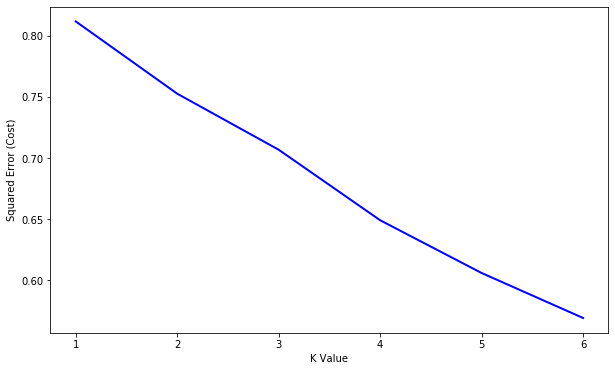

In [27]:

cost =[] 
for i in range(1, 7): 
    kmeans = KMeans(n_clusters = i, max_iter = 1000) 
    kmeans.fit(manhattan_grouped_clustering) 
      
    # calculating squared error for the clustered points 
    cost.append(kmeans.inertia_)
    
# plotting cost against K values
plt.figure(figsize=(10,6))
plt.plot(range(1, 7), cost, color ='b', linewidth ='2') 
plt.xlabel("K Value") 
plt.ylabel("Squared Error (Cost)") 
plt.show()

**The optimum value of K is 4, visible at the elbow point. We will now run K-means clustering for K=.**

In [50]:
# setting number of clusters
kclusters = 4

# running k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 1, 1, 1, 3, 0, 1], dtype=int32)

### Make a new dataframe with cluster labels along with neighborhood data and common venues data

In [29]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan

# merging neighborhoods_venues_sorted with manhattan to add latitude/longitude for each Neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
manhattan_merged.dropna(inplace=True)
manhattan_merged['Cluster Labels'] = manhattan_merged['Cluster Labels'].astype(int)

print(manhattan_merged.shape)
manhattan_merged

(40, 15)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0,Sandwich Place,Gym,American Restaurant,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Seafood Restaurant,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bakery,Cocktail Bar,Coffee Shop,Spa,American Restaurant,Salon / Barbershop,Optical Shop,Bar,Dim Sum Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Mobile Phone Shop,Pizza Place,Grocery Store,Chinese Restaurant,Latin American Restaurant,Tapas Restaurant,New American Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Café,Bakery,Pizza Place,Lounge,Restaurant,Park,Chinese Restaurant,Deli / Bodega,American Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Coffee Shop,Mexican Restaurant,Café,Deli / Bodega,Chinese Restaurant,Sushi Restaurant,Cocktail Bar,Yoga Studio,Caribbean Restaurant
5,Manhattan,Manhattanville,40.816934,-73.957385,0,Coffee Shop,Seafood Restaurant,Italian Restaurant,Deli / Bodega,Park,Fried Chicken Joint,Mexican Restaurant,Food & Drink Shop,Bank,Bar
6,Manhattan,Central Harlem,40.815976,-73.943211,1,Chinese Restaurant,Gym / Fitness Center,African Restaurant,American Restaurant,Bar,Fried Chicken Joint,Seafood Restaurant,French Restaurant,Café,Market
7,Manhattan,East Harlem,40.792249,-73.944182,0,Mexican Restaurant,Bakery,Deli / Bodega,Thai Restaurant,Latin American Restaurant,Pizza Place,Dance Studio,Steakhouse,Doctor's Office,Cocktail Bar
8,Manhattan,Upper East Side,40.775639,-73.960508,1,Italian Restaurant,Bakery,Exhibit,Gym / Fitness Center,Spa,Cosmetics Shop,Hotel,Juice Bar,Pizza Place,Yoga Studio
9,Manhattan,Yorkville,40.775930,-73.947118,0,Coffee Shop,Italian Restaurant,Gym,Bar,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Wine Shop,Japanese Restaurant,Diner



# Analysis <a name="analysis"></a>

In this section, we will analyze the five clusters to illuminate which cluster has the most restaurants as the most common venues. 

### Cluster 0:

In [33]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Gym,American Restaurant,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Seafood Restaurant,Pizza Place
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Coffee Shop,Spa,American Restaurant,Salon / Barbershop,Optical Shop,Bar,Dim Sum Restaurant
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Pizza Place,Grocery Store,Chinese Restaurant,Latin American Restaurant,Tapas Restaurant,New American Restaurant,Park
3,Inwood,Mexican Restaurant,Café,Bakery,Pizza Place,Lounge,Restaurant,Park,Chinese Restaurant,Deli / Bodega,American Restaurant
4,Hamilton Heights,Pizza Place,Coffee Shop,Mexican Restaurant,Café,Deli / Bodega,Chinese Restaurant,Sushi Restaurant,Cocktail Bar,Yoga Studio,Caribbean Restaurant
5,Manhattanville,Coffee Shop,Seafood Restaurant,Italian Restaurant,Deli / Bodega,Park,Fried Chicken Joint,Mexican Restaurant,Food & Drink Shop,Bank,Bar
7,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Thai Restaurant,Latin American Restaurant,Pizza Place,Dance Studio,Steakhouse,Doctor's Office,Cocktail Bar
9,Yorkville,Coffee Shop,Italian Restaurant,Gym,Bar,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Wine Shop,Japanese Restaurant,Diner
10,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Sushi Restaurant,Café,Gym,Burger Joint,Gym / Fitness Center,Sporting Goods Shop
12,Upper West Side,Italian Restaurant,Wine Bar,Bakery,Coffee Shop,Ice Cream Shop,Seafood Restaurant,Middle Eastern Restaurant,Bagel Shop,Mediterranean Restaurant,Bar


### Cluster 1:

In [35]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Central Harlem,Chinese Restaurant,Gym / Fitness Center,African Restaurant,American Restaurant,Bar,Fried Chicken Joint,Seafood Restaurant,French Restaurant,Café,Market
8,Upper East Side,Italian Restaurant,Bakery,Exhibit,Gym / Fitness Center,Spa,Cosmetics Shop,Hotel,Juice Bar,Pizza Place,Yoga Studio
11,Roosevelt Island,Deli / Bodega,Park,Gym / Fitness Center,Greek Restaurant,Dog Run,Liquor Store,Outdoors & Recreation,Sandwich Place,Scenic Lookout,Food & Drink Shop
13,Lincoln Square,Plaza,Gym / Fitness Center,Café,Italian Restaurant,Concert Hall,Performing Arts Venue,Theater,American Restaurant,Wine Shop,Indie Movie Theater
14,Clinton,Theater,Coffee Shop,Gym / Fitness Center,Gym,Wine Shop,Hotel,Italian Restaurant,Sandwich Place,Pizza Place,Spa
15,Midtown,Hotel,Clothing Store,Coffee Shop,Theater,Pizza Place,Cuban Restaurant,Spa,Tailor Shop,Café,Gym
16,Murray Hill,Sandwich Place,Coffee Shop,Japanese Restaurant,Pizza Place,Gym / Fitness Center,Mediterranean Restaurant,Burger Joint,Hotel,Chinese Restaurant,Steakhouse
21,Tribeca,Park,Italian Restaurant,Wine Bar,Café,Spa,American Restaurant,Art Gallery,Steakhouse,Skate Park,Scenic Lookout
26,Morningside Heights,Park,American Restaurant,Coffee Shop,Bookstore,Deli / Bodega,Burger Joint,Tennis Court,Pizza Place,Supermarket,Café
28,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Memorial Site,Beer Garden,Gourmet Shop,Plaza,Food Court,Shopping Mall


### Cluster 2:

In [36]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Boat or Ferry,Park,Bar,Pet Service,Gas Station,Farmers Market,German Restaurant,Gym / Fitness Center,Baseball Field,Harbor / Marina


### Cluster 3:

In [41]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Cluster 4:

In [51]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


# Results and Discussion <a name="results and discussion"></a>



We can see that Cluster 0 is the cluster with the most restaurants as the most common venue. We will select Cluster 0 as our final cluster to create a map. This will provide us with the neighborhoods we will further use to visualize the results. We will plot the mean value of Mexican restaurants for each selected neighborhood in the cluster to study the presence of competition in each neighborhood.


In [43]:
manhattan_select = manhattan_merged[manhattan_merged['Cluster Labels'] == 0]

print(manhattan_select.shape)
manhattan_select

(20, 15)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0,Sandwich Place,Gym,American Restaurant,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Seafood Restaurant,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bakery,Cocktail Bar,Coffee Shop,Spa,American Restaurant,Salon / Barbershop,Optical Shop,Bar,Dim Sum Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Mobile Phone Shop,Pizza Place,Grocery Store,Chinese Restaurant,Latin American Restaurant,Tapas Restaurant,New American Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Café,Bakery,Pizza Place,Lounge,Restaurant,Park,Chinese Restaurant,Deli / Bodega,American Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Coffee Shop,Mexican Restaurant,Café,Deli / Bodega,Chinese Restaurant,Sushi Restaurant,Cocktail Bar,Yoga Studio,Caribbean Restaurant
5,Manhattan,Manhattanville,40.816934,-73.957385,0,Coffee Shop,Seafood Restaurant,Italian Restaurant,Deli / Bodega,Park,Fried Chicken Joint,Mexican Restaurant,Food & Drink Shop,Bank,Bar
7,Manhattan,East Harlem,40.792249,-73.944182,0,Mexican Restaurant,Bakery,Deli / Bodega,Thai Restaurant,Latin American Restaurant,Pizza Place,Dance Studio,Steakhouse,Doctor's Office,Cocktail Bar
9,Manhattan,Yorkville,40.775930,-73.947118,0,Coffee Shop,Italian Restaurant,Gym,Bar,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Wine Shop,Japanese Restaurant,Diner
10,Manhattan,Lenox Hill,40.768113,-73.958860,0,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Sushi Restaurant,Café,Gym,Burger Joint,Gym / Fitness Center,Sporting Goods Shop
12,Manhattan,Upper West Side,40.787658,-73.977059,0,Italian Restaurant,Wine Bar,Bakery,Coffee Shop,Ice Cream Shop,Seafood Restaurant,Middle Eastern Restaurant,Bagel Shop,Mediterranean Restaurant,Bar


In [44]:
manhattan_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# adding selected markers to map
for lat, lng, label in zip(manhattan_select['Latitude'], manhattan_select['Longitude'], manhattan_select['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(manhattan_map)  
    
manhattan_map




The map shoes the neigborohoods in cluster 2, which depicts the 20 neighborhoods we will use to analyze.

### Get  average venues data of each selected neighborhood from Manhattan

In [45]:
manhattan_grouped_select = pd.DataFrame()
manhattan_grouped_select['Neighborhood'] = manhattan_select['Neighborhood']

manhattan_grouped_select = manhattan_grouped_select.join(manhattan_grouped.set_index('Neighborhood'), on='Neighborhood')
manhattan_grouped_select.dropna(inplace=True)
manhattan_grouped_select.sort_values('Mexican Restaurant',ascending=False,inplace=True)
manhattan_grouped_select.reset_index(drop=True,inplace=True)

print(manhattan_grouped_select.shape)
manhattan_grouped_select.head()

(20, 322)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Cente

### There are 20 neighborhoods in Manhattan we will use to get the average venues data

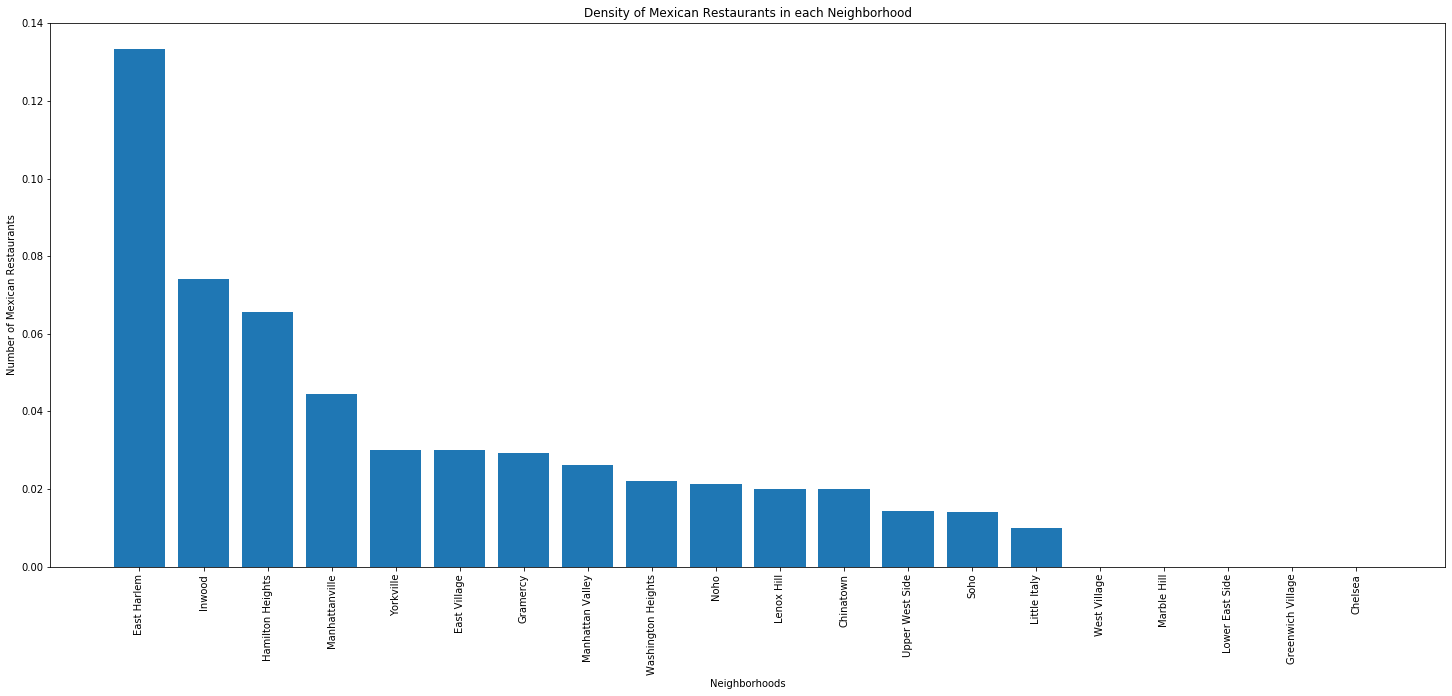

In [60]:
label = list(manhattan_grouped_select['Neighborhood'])
height = list(manhattan_grouped_select['Mexican Restaurant'])

index = np.arange(len(label))

plt.figure(figsize=(25,10))
plt.bar(index,height)
plt.xlabel('Neighborhoods')
plt.ylabel('Average Number of Mexican Restaurants')
plt.xticks(rotation=90)
plt.xticks(index,label)
plt.title('Density of Mexican Restaurants in each Neighborhood')
plt.show()

The graph depicts 20 neighborhoods obtained from Cluster 0, which is the cluster with the most restaurants as the most common venue. Based on the graph, you can see that the first neighborhood, East Harlem, has the most competiton for Mexican Restaurants in Manhattan, indicating that it has the greatest obstacles in opening a new restaurant. Of these neighborhoods, it is also the most populated. East Harlem has at least double the competiton than the other neighborhoods. Inwood is the second neighborhood with the most Mexican restaurants, followed by Inwood. However, the following neighborhoods have moderate competition, which will enable a new business to establish itself easier: 

  1. Manhattanville
  * Yorkville
  * East Village
  * Gramercy
  * Manhattan Valley
  * Washington Heights
  * Noho
  * Lenox Hill
  * Chinatown



# Conclusion <a name="conclusion"></a>


This project aimed at identifying a potenial neighborhood to open a restaurant in New York City. For which neighborhood in New York City offers the the greatest population denisity and which neighborhood offers the greatest per capita income. In this study, we conlcluded that Manhattan offers both, the most people and also the greatest purchasing power of the population of the other four boroughs in New York. 

We obtained the location data of different types of venues with  Foursquare API. This locational data aided us in identifying the which cluster had restaurants as the most common venue in Manhattan.

Neighborhoods were partitioned into different clusters using K-means clustering algorithm. Further analysis identified that for a Mexican restaurant, East Harlem provides the most competiton, which will provide a harder ground to break. However, East Harlem is the most populated of the 20 neighborhoods analyzed. The 9 neighborhoods (Manhattanville, Yorkville, East Village, Gramercy, Manhattan Valley, Washington Heights, Noho, Lenox Hill, Chinatown) with moderate competion also had lower population density than the top 3 neighborhoods with the most average number of Mexcan Restaurants. 


This analysis can be helpful for individuals looking into opening a Mexican restaurant. This will provide an analysis of whether the venture is feasible and what the competitive landscape is. This can benefit investors that seek to invest in the opening of the company by highlighting potential areas to start or expand a business. Lastly, this can assist residents or visitors by providing the areas with the most amount of Mexican restaurants per neighborhood.